<a href="https://colab.research.google.com/github/cxbxmxcx/GenReality/blob/master/GEN_3_conv_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import math
import time
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchsummary import summary
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from IPython.display import clear_output

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
# convert data to torch.FloatTensor
transform = transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor(), 
])

# load the training and test datasets
train_data = datasets.CIFAR10(root='data', train=True,
                                   download=True, transform=transform)
test_data = datasets.CIFAR10(root='data', train=False,
                                  download=True, transform=transform)

Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [ ]:
batch_size = 2048
epochs = 100
learning_rate = 1e-3

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [ ]:
def imshow(img):    
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image
    
# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

def plot_images(images, labels, no):  
  rows = int(math.sqrt(no))
  plt.ion()
  fig = plt.figure(figsize=(rows*2, rows*2))      
  for idx in np.arange(no):
      ax = fig.add_subplot(rows, no/rows, idx+1, xticks=[], yticks=[])
      imshow(images[idx])
      ax.set_title(classes[labels[idx]]) 
  time.sleep(0.1)
  plt.pause(0.0001)     

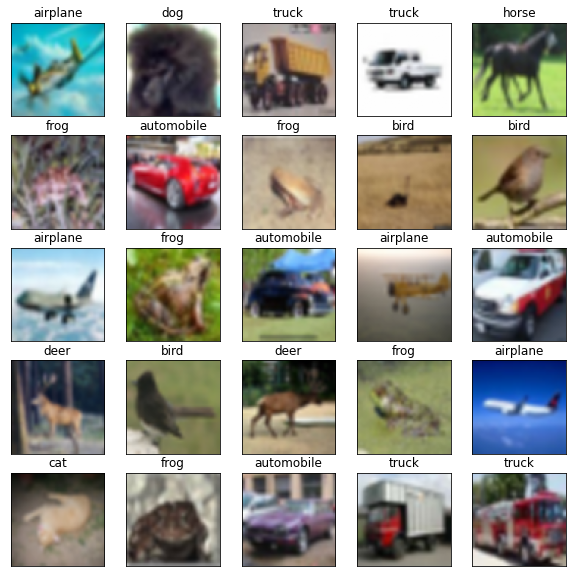

In [ ]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

plot_images(images,labels,25)

In [ ]:
class Flatten(nn.Module):
  def forward(self, input):
    return input.view(input.size(0), -1)

class UnFlatten(nn.Module):
  def forward(self, input, size=1024):
    return input.view(input.size(0), size, 1, 1)

In [ ]:
class ConvVAE(nn.Module):
  def __init__(self, image_channels=3, h_dim=1024, z_dim=32):
    super(ConvVAE, self).__init__()
    self.encoder = nn.Sequential(
      nn.Conv2d(image_channels, 32, kernel_size=4, stride=2),
      nn.ReLU(),
      nn.Conv2d(32, 64, kernel_size=4, stride=2),
      nn.ReLU(),
      nn.Conv2d(64, 128, kernel_size=4, stride=2),
      nn.ReLU(),
      nn.Conv2d(128, 256, kernel_size=4, stride=2),
      nn.ReLU(),
      Flatten()
    )     
      
    self.fc1 = nn.Linear(h_dim, z_dim)
    self.fc2 = nn.Linear(h_dim, z_dim)
    self.fc3 = nn.Linear(z_dim, h_dim)
      
    self.decoder = nn.Sequential(
      UnFlatten(),
      nn.ConvTranspose2d(h_dim, 128, kernel_size=5, stride=2),
      nn.ReLU(),
      nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2),
      nn.ReLU(),
      nn.ConvTranspose2d(64, 32, kernel_size=6, stride=2),
      nn.ReLU(),
      nn.ConvTranspose2d(32, image_channels, kernel_size=6, stride=2),
      nn.Sigmoid(),
    )    

  def reparameterize(self, mu, logvar):
    std = logvar.mul(0.5).exp_()
    # return torch.normal(mu, std)
    esp = torch.randn(*mu.size())
    esp = esp.to(device)
    z = mu + std * esp
    return z
    
  def bottleneck(self, h):
    mu, logvar = self.fc1(h), self.fc2(h)
    z = self.reparameterize(mu, logvar)
    return z, mu, logvar

  def encode(self, x):
    h = self.encoder(x)
    z, mu, logvar = self.bottleneck(h)
    return z, mu, logvar

  def decode(self, z):
    z = self.fc3(z)
    z = self.decoder(z)
    return z

  def forward(self, x):
    z, mu, logvar = self.encode(x)
    z = self.decode(z)
    return z, mu, logvar

model = ConvVAE()
model.cuda(device)
print(model)


ConvVAE(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2))
    (5): ReLU()
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2))
    (7): ReLU()
    (8): Flatten()
  )
  (fc1): Linear(in_features=1024, out_features=32, bias=True)
  (fc2): Linear(in_features=1024, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1024, bias=True)
  (decoder): Sequential(
    (0): UnFlatten()
    (1): ConvTranspose2d(1024, 128, kernel_size=(5, 5), stride=(2, 2))
    (2): ReLU()
    (3): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(2, 2))
    (4): ReLU()
    (5): ConvTranspose2d(64, 32, kernel_size=(6, 6), stride=(2, 2))
    (6): ReLU()
    (7): ConvTranspose2d(32, 3, kernel_size=(6, 6), stride=(2, 2))
    (8): Sigmoid()
  )
)


In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

def loss_fn(recon_x, x, mu, logvar):
  BCE = F.binary_cross_entropy(recon_x, x, size_average=False)
  # BCE = F.mse_loss(recon_x, x, size_average=False)

  # see Appendix B from VAE paper:
  # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
  # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
  KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

  return BCE + KLD, BCE, KLD

Epoch: 11 Training Loss: 29832469680.000


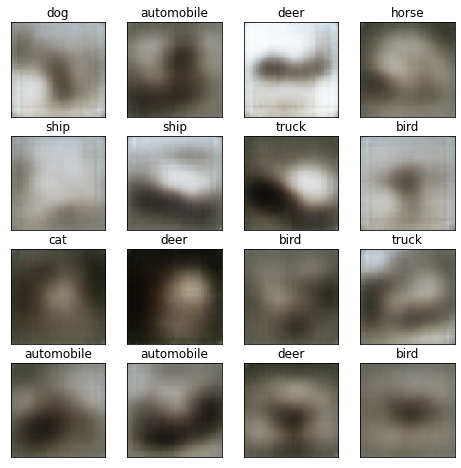

In [ ]:
for epoch in range(epochs):    
    train_loss = 0.0    
    for data in train_loader:        
        images, labels = data        
        optimizer.zero_grad()  
        images = images.to(device)
        generated, mu, logvar = model(images)
        loss, bce, kld = loss_fn(generated, images, mu, logvar) 
        loss.backward()        
        optimizer.step()
        train_loss += loss.item()*images.size(0)
            
    train_loss = train_loss/len(train_loader)
    clear_output()
    print(f'Epoch: {epoch+1} Training Loss: {train_loss:.3f}')    
    plot_images(generated.cpu().data,labels,16)   
    